## 1 Train Model

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
# 设置超参数
BATCH_SIZE = 32
NUM_WORKERS = 2
LR = 5e-3       # 学习率
EMBEDDING_DIM = 128        # 嵌入层维度
HIDDEN_DIM = 256           # 隐藏层维度
EPOCH_NUM = 4                 # 训练轮数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def prepare_data():
    # 读入预处理的数据
    datas = np.load("./data/tang.npz", allow_pickle=True)
    data = datas['data']
    ix2word = datas['ix2word'].item()
    word2ix = datas['word2ix'].item()

    # 转为torch.Tensor
    data = torch.from_numpy(data)
    dataloader = DataLoader(data,
                         batch_size = BATCH_SIZE,
                         shuffle = True,
                         num_workers = NUM_WORKERS)
    return dataloader, ix2word, word2ix

In [4]:
dataloader, ix2word, word2ix = prepare_data()

In [5]:
for i, item in enumerate(dataloader):
    print(item)
    print(item.shape)  # (batch_size, token_length)
    break

tensor([[8292, 8292, 8292,  ..., 7113, 7435, 8290],
        [8292, 8292, 8292,  ..., 6495, 7435, 8290],
        [8291, 6276, 3788,  ...,  676, 7416, 7145],
        ...,
        [8292, 8292, 8292,  ...,  595, 7435, 8290],
        [8292, 8292, 8292,  ..., 4998, 7435, 8290],
        [8292, 8292, 8292,  ..., 1508, 7435, 8290]], dtype=torch.int32)
torch.Size([32, 125])


In [6]:
class PoetryModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoetryModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=2)
        self.linear = nn.Linear(self.hidden_dim, vocab_size)

    def forward(self, inputs, hidden = None):
        seq_len, batch_size = inputs.size()

        if hidden is None:
            h_0 = inputs.data.new(2, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = inputs.data.new(2, batch_size, self.hidden_dim).fill_(0).float()
        else:
            h_0, c_0 = hidden

        embeds = self.embedding(inputs)
        outputs, hidden = self.lstm(embeds, (h_0, c_0))
        outputs = self.linear(outputs.view(seq_len * batch_size, -1))
        return outputs, hidden

In [7]:
model_path = None          # 预训练模型路径
model = PoetryModel(len(word2ix), EMBEDDING_DIM, HIDDEN_DIM)
if model_path:
    model.load_state_dict(torch.load(model_path))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [8]:
# train
from tqdm import tqdm
train_losses = []
train_counter = []

for epoch in range(0, EPOCH_NUM):
    model.train()

    loop = tqdm(dataloader, total = len(dataloader))
    for data in loop:
        data = data.long().transpose(1, 0).contiguous()
        data = data.to(device)
        inputs, target = data[:-1, :], data[1:, :]
        outputs, _ = model(inputs)
        loss = criterion(outputs, target.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        if len(train_counter) == 0:
            train_counter.append(len(data))
        else:
            train_counter.append(train_counter[-1] + len(data))

        loop.set_description(f'Epoch [{epoch + 1}/{EPOCH_NUM}]')
        loop.set_postfix(loss = loss.item())

    print('[epoch:%d] <Train> Loss: %.03f' % (epoch + 1, train_losses[-1]))

print('Train has finished, total epoch is %d' % EPOCH_NUM)
torch.save(model.state_dict(), './' + str(EPOCH_NUM) +'epoch-model.pth')
torch.save(optimizer.state_dict(), './' + str(EPOCH_NUM) +'epoch-optimizer.pth')

Epoch [1/4]: 100%|██████████| 1800/1800 [02:17<00:00, 13.07it/s, loss=2.61]


[epoch:1] <Train> Loss: 2.610


Epoch [2/4]: 100%|██████████| 1800/1800 [02:17<00:00, 13.12it/s, loss=2.07]


[epoch:2] <Train> Loss: 2.072


Epoch [3/4]: 100%|██████████| 1800/1800 [02:16<00:00, 13.20it/s, loss=2]   


[epoch:3] <Train> Loss: 2.000


Epoch [4/4]: 100%|██████████| 1800/1800 [02:16<00:00, 13.19it/s, loss=1.81]

[epoch:4] <Train> Loss: 1.813
Train has finished, total epoch is 4


C:\Users\Suxyuuu\AppData\Local\Temp\ipykernel_21468\4166752260.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


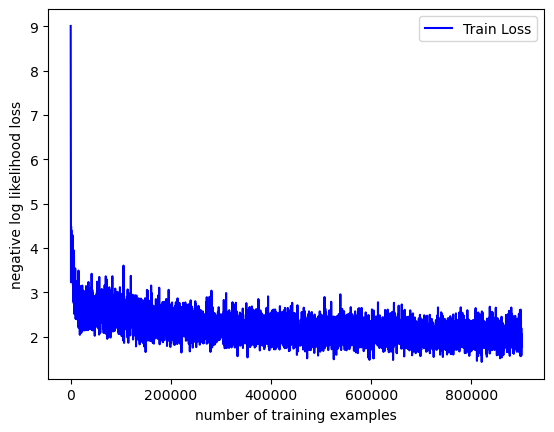

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('number of training examples')
plt.ylabel('negative log likelihood loss')
plt.legend(['Train Loss'], loc='upper right')
fig.show()

## 2 Poetry

In [10]:
# load model
model_path = './4epoch-model.pth'       # 模型路径
start_words = '湖光秋月两相和'             # 唐诗的第一句
max_gen_len = 125                       # 生成唐诗的最长长度

In [11]:
def generate(start_words, ix2word, word2ix):
    # 读取模型
    model = PoetryModel(len(word2ix), EMBEDDING_DIM, HIDDEN_DIM)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # 读取唐诗的第一句
    results = list(start_words)
    start_word_len = len(start_words)

    # 设置第一个词为<START>
    inputs = torch.Tensor([word2ix['<START>']]).view(1, 1).long()
    inputs = inputs.to(device)
    hidden = None

    # 生成唐诗
    for i in range(max_gen_len):
        outputs, hidden = model(inputs, hidden)
        # 读取第一句
        if i < start_word_len:
            w = results[i]
            inputs = inputs.data.new([word2ix[w]]).view(1, 1)
        # 生成后面的句子
        else:
            top_index = outputs.data[0].topk(1)[1][0].item()
            w = ix2word[top_index]
            results.append(w)
            inputs = inputs.data.new([top_index]).view(1, 1)
        # 结束标志
        if w == '<EOP>':
            del results[-1]
            break

    poetry_str = ""
    for ch in results:
        poetry_str += ch
        if ch == u'。':
            poetry_str += '\n'
    return poetry_str

In [12]:
results = generate(start_words, ix2word, word2ix)
print(results)

湖光秋月两相和，水石无人见山色。
山中日月照春风，春风吹落花前开。
春风吹落花落时，春风吹落花前开。
春风吹落花落时，春风吹落花前开。
春风吹落花落时，春风吹落花前开。
春风吹落花落时，春风吹落花前开。
春风吹，春色长，不见春风吹。
不知此曲不相见，不见春风吹不定


## 3 Acrostic poetry

In [13]:
# load model
model_path = './4epoch-model.pth'       # 模型路径
start_words_acrostic  = '湖光秋月两相和'   # 藏头的内容
max_gen_len_acrostic = 125              # 生成唐诗的最长长度

In [14]:
def gen_acrostic(start_words, ix2word, word2ix):
    # 读取模型
    model = PoetryModel(len(word2ix), EMBEDDING_DIM, HIDDEN_DIM)
    model.load_state_dict(torch.load(model_path))
    model.to(device)

    # 读取唐诗的“头”
    results = []
    start_word_len = len(start_words)

    # 设置第一个词为<START>
    inputs = (torch.Tensor([word2ix['<START>']]).view(1, 1).long())
    inputs = inputs.to(device)
    hidden = None

    index = 0            # 指示已生成了多少句
    pre_word = '<START>' # 上一个词

    # 生成藏头诗
    for i in range(max_gen_len_acrostic):
        outputs, hidden = model(inputs, hidden)
        top_index = outputs.data[0].topk(1)[1][0].item()
        w = ix2word[top_index]

        # 如果遇到标志一句的结尾，喂入下一个“头”
        if (pre_word in {u'。', u'！', '<START>'}):
            # 如果生成的诗已经包含全部“头”，则结束
            if index == start_word_len:
                break
            # 把“头”作为输入喂入模型
            else:
                w = start_words[index]
                index += 1
                inputs = (inputs.data.new([word2ix[w]])).view(1, 1)

        # 否则，把上一次预测作为下一个词输入
        else:
            inputs = (inputs.data.new([word2ix[w]])).view(1, 1)
        results.append(w)
        pre_word = w

    poetry_str = ""
    for ch in results:
        poetry_str += ch
        if ch == u'。':
            poetry_str += '\n'
    return poetry_str

In [15]:
results_acrostic = gen_acrostic(start_words_acrostic, ix2word, word2ix)
print(results_acrostic)

湖上春风起，江南春草深。
光辉日月好，独坐夜深深。
秋色生春色，清风入竹扉。
月明花下月，花落夜灯明。
两岸花初发，新晴月满林。
相思无限客，春色满林阴。
和气随风起，清风入夜深。

